In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
sess = tf.InteractiveSession()

# Linear model for regression

For $n$ samples $(x_i, y_i)_{i=1,\ldots, n}$ :
$$ y_i = w_1 x_i + w_0 $$ 

In [2]:
n_samples = 10
sample_xs = tf.constant(
    value=np.random.uniform(low=0, high=1, size=(n_samples, 1)), 
    name='features')
sample_xs

<tf.Tensor 'features:0' shape=(10, 1) dtype=float64>

In [3]:
sample_xs.eval()

array([[ 0.94969008],
       [ 0.57846953],
       [ 0.32921631],
       [ 0.5443468 ],
       [ 0.67770543],
       [ 0.43186244],
       [ 0.72000732],
       [ 0.48242283],
       [ 0.91933701],
       [ 0.44213133]])

In [4]:
sample_noises = tf.constant(
    value=np.random.normal(loc=0, scale=.5, size=n_samples),
    shape=(n_samples, 1)
)

d = 2
oracle_w = np.array([1., -2.]).reshape((d, 1))

sample_ys = oracle_w[0] + oracle_w[1] * sample_xs + sample_noises
sample_ys

<tf.Tensor 'add_1:0' shape=(10, 1) dtype=float64>

In [5]:
sample_ys.eval()

array([[-1.12815696],
       [-0.14840324],
       [ 0.3616649 ],
       [-0.70211137],
       [-0.88470248],
       [-0.00585898],
       [ 0.55005853],
       [-0.08840744],
       [-0.46108432],
       [ 0.54603037]])

## Vectorized reformulation

[Prof Ng](https://www.youtube.com/watch?v=v4kKgCiF1fo) to the rescue for a refresher about matrix-matrix multiplication :)
$$ \underbrace{\mathbf{y}}_{n \times 1} = \underbrace{\mathbf{X}}_{n \times d} \cdot \underbrace{\mathbf{w}}_{d \times 1} $$

In [6]:
x0 = np.repeat(1.0, n_samples).reshape((n_samples, 1))
x1 = sample_xs.eval()

X = tf.constant(np.hstack([x0, x1]), name='X')
X

<tf.Tensor 'X:0' shape=(10, 2) dtype=float64>

In [7]:
y = tf.add(tf.matmul(X, oracle_w), sample_noises, name='y')
y

<tf.Tensor 'y:0' shape=(10, 1) dtype=float64>

In [8]:
y.eval()

array([[-1.12815696],
       [-0.14840324],
       [ 0.3616649 ],
       [-0.70211137],
       [-0.88470248],
       [-0.00585898],
       [ 0.55005853],
       [-0.08840744],
       [-0.46108432],
       [ 0.54603037]])

## Visualisation

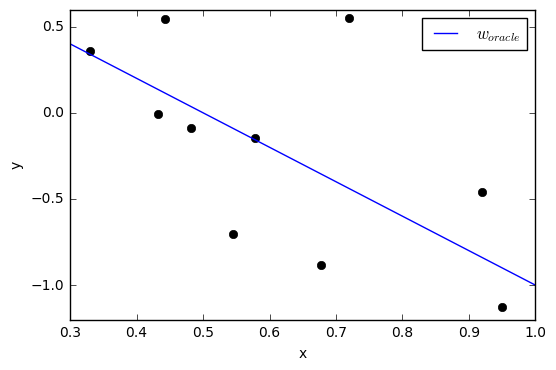

In [9]:
def fitted_line(w, x_lim, **plot_args):
    x_0, x_1 = x_lim
    y_0, y_1 = w[0] + w[1] * np.array(x_lim)
    plt.plot(x_lim, [y_0, y_1], **plot_args)
    
plt.plot(sample_xs.eval(), sample_ys.eval(), 'ko')
fitted_line(oracle_w, plt.xlim(), label='$w_{oracle}$')
plt.legend(); plt.xlabel('x'); plt.ylabel('y');